#Cài đặt PySpark

In [62]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [63]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

#Câu 1

In [64]:
import random
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

In [65]:
# Tạo SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('k-Means Clustering') \
    .getOrCreate()

In [66]:
# Phát sinh dữ liệu
random.seed(42)
data = [(
    float(random.randint(1, 100)), float(random.randint(1, 100))
) for _ in range(100)]

# Xác định schema
schema = StructType([
    StructField('x', FloatType(), True),
    StructField('y', FloatType(), True)
])

# Tạo DataFrame
df = spark.createDataFrame(data, schema)

In [67]:
# Khởi tạo giá trị ban đầu cho các centroids
k = 3  # Số lượng cluster
centroids = [(float(random.randint(1, 100)), float(random.randint(1, 100))) for _ in range(k)]


def euclidean_distance(a, b):
    return np.sqrt(((np.array(a) - np.array(b)) ** 2).sum())


def closest_centroid(p, centroids):
    distances = [euclidean_distance(p, c) for c in centroids]
    return distances.index(min(distances))

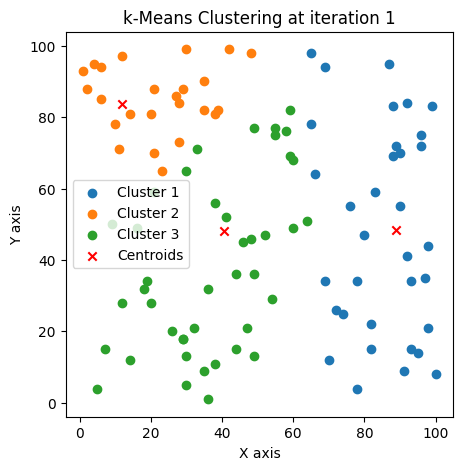

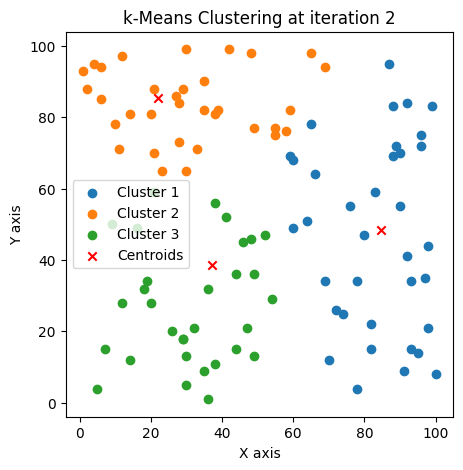

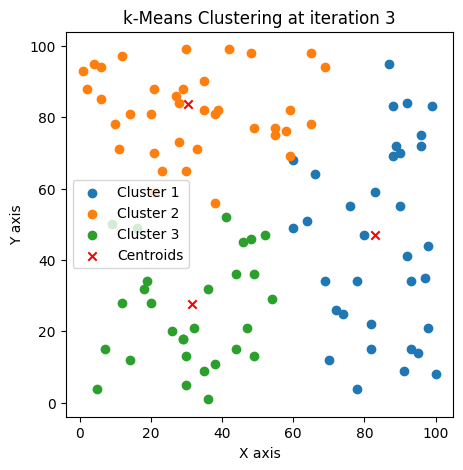

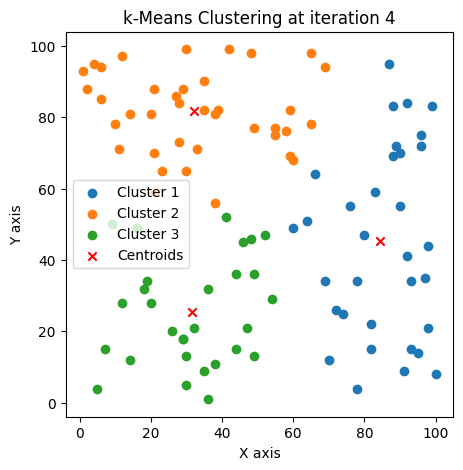

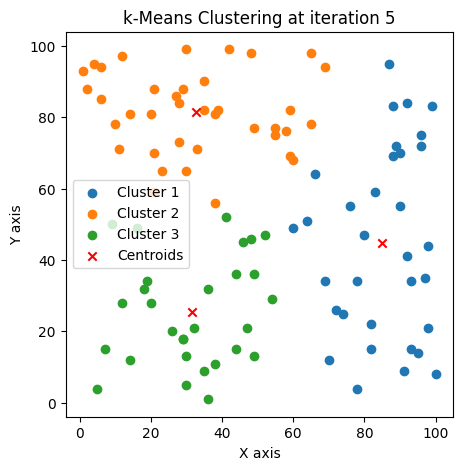

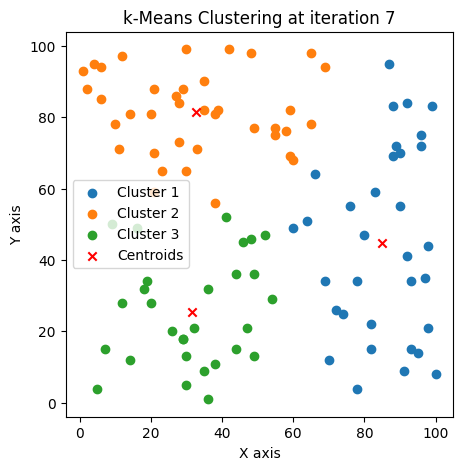

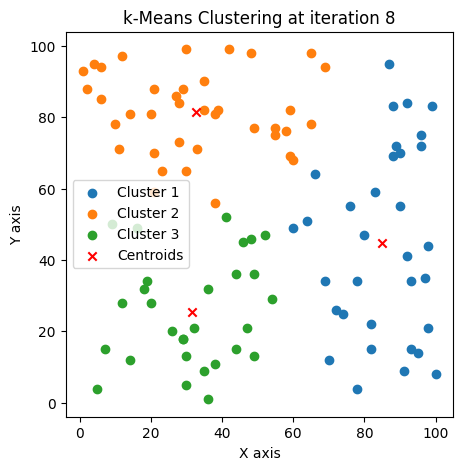

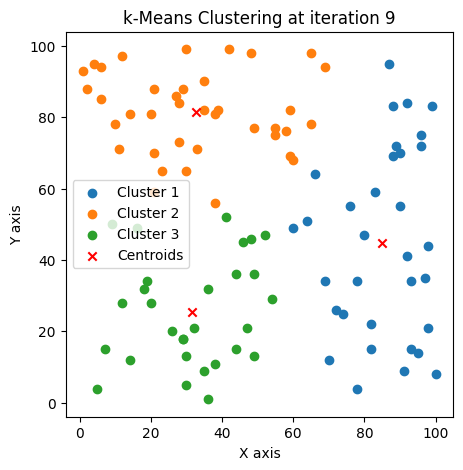

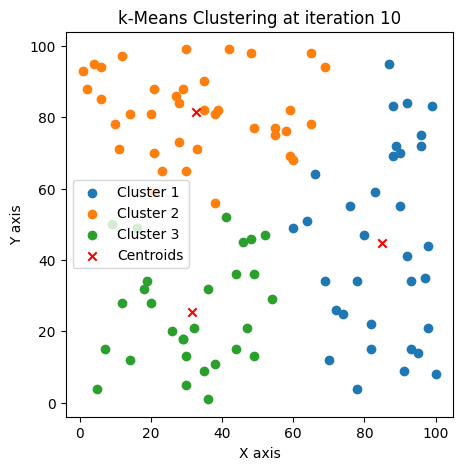

In [68]:
# Chạy thuật toán k-Means
max_iterations = 10

for i in range(max_iterations):
    # Gán điểm dữ liệu vào centroid gần nhất
    df_c = df.rdd.map(
        lambda r: (closest_centroid((r.x, r.y), centroids), (r.x, r.y, 1))
    ).reduceByKey(
        lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2])
    ).mapValues(
        lambda v: (v[0] / v[2], v[1] / v[2])
    ).sortByKey().collect()

    centroids = [c[1] for c in df_c]

    # Trực quan hóa kết quả
    plt.figure(figsize=(5, 5))
    for j in range(k):
        cluster_df = df.rdd.filter(lambda r: closest_centroid((r.x, r.y), centroids) == j).collect()
        x_coords = [r.x for r in cluster_df]
        y_coords = [r.y for r in cluster_df]
        plt.scatter(x_coords, y_coords, label=f'Cluster {j + 1}')

    plt.scatter(*zip(*centroids), color='red', marker='x', label='Centroids')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title(f'k-Means Clustering at iteration {i + 1}')
    plt.legend()
    plt.show()

#Câu 2

In [69]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import random
import matplotlib.pyplot as plt

In [70]:
# Tạo SparkSession
spark = SparkSession.builder.master("local").appName("CURE_Clustering").getOrCreate()

In [71]:
# Số điểm dữ liệu được tạo
num_points = 100
# Số lượng cluster mong muốn
k = 3
#Tạo dữ liệu ngẫu nhiên có 2 chiều (x, y)
data = [(random.randint(1, 100), random.randint(1, 100)) for _ in range(num_points)]
#Tạo DataFrame từ dữ liệu, đặt tên cột là 'x' và 'y'
df = spark.createDataFrame(data, ['x', 'y'])
#Sử dụng VectorAssembler để gom các cột 'x' và 'y' thành một cột vector 'features'
assembler = VectorAssembler(inputCols=['x', 'y'], outputCol='features')
df = assembler.transform(df).select('features')

In [72]:
#Hàm tính khoảng cách giữa 2 điểm dữ liệu
def distance(a, b):
    return float(a.squared_distance(b)) ** 0.5
#Thuật toán CURE Clustering
def cure_clustering(df, k, num_representatives):
    clusters = [[row.features] for row in df.collect()]
    while len(clusters) > k:
        min_dist = float('inf')
        pair = (0, 1)
        for i, ci in enumerate(clusters):
            for j, cj in enumerate(clusters[i+1:], i+1):
                # Tìm cặp cluster có khoảng cách nhỏ nhất và gộp chúng lại
                dist = min(distance(a, b) for a in ci for b in cj)
                if dist < min_dist:
                    min_dist = dist
                    pair = (i, j)
        # Chọn các điểm đại diện cho cluster mới được tạo
        new_cluster = clusters[pair[0]] + clusters[pair[1]]
        new_cluster.sort(key=lambda x: (x[0], x[1]))
        representatives = new_cluster[:num_representatives]
        # Thêm các điểm đại diện vào danh sách cluster
        clusters.append(representatives)
        # Xoá 2 cluster đã gộp lại
        clusters.pop(max(pair))
        clusters.pop(min(pair))
        # Hiển thị kết quả
        visualize_clusters(clusters)
# Hàm vẽ đồ thị biểu diễn các cluster
def visualize_clusters(clusters):
    fig, ax = plt.subplots()
    centroids = []
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k'] # danh sách các màu sắc
    for i, cluster in enumerate(clusters):
        xs, ys = zip(*[(point[0], point[1]) for point in cluster])
        ax.scatter(xs, ys, c=colors[i%len(colors)], alpha=0.5)
        centroid = np.mean(cluster, axis=0)
        centroids.append(centroid)
    centroids_xs, centroids_ys = zip(*[(point[0], point[1]) for point in centroids])
    ax.scatter(centroids_xs, centroids_ys, c='black', marker='*', s=200) # vẽ centroids
    plt.show()

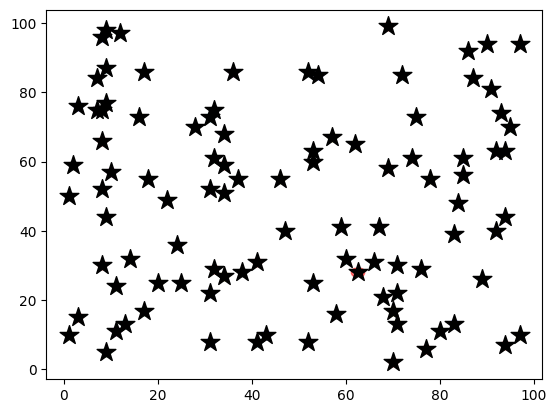

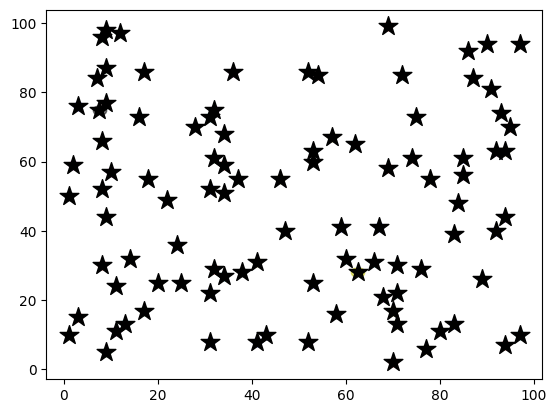

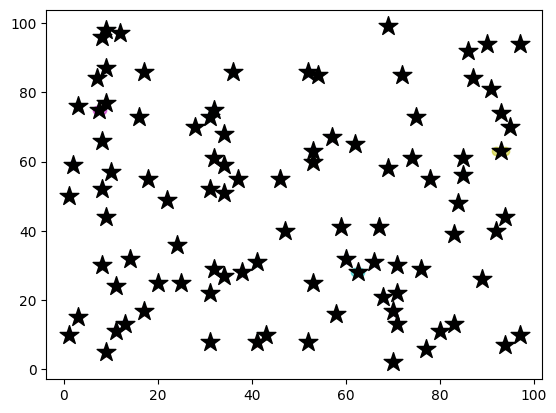

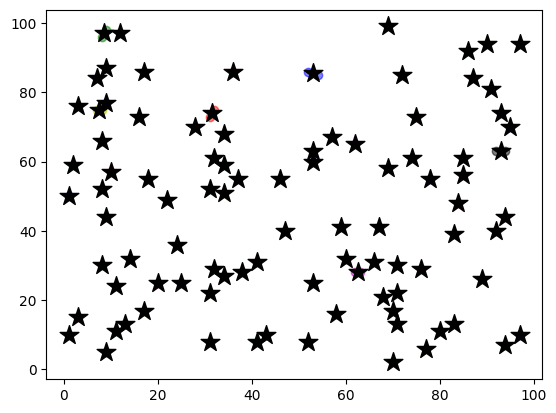

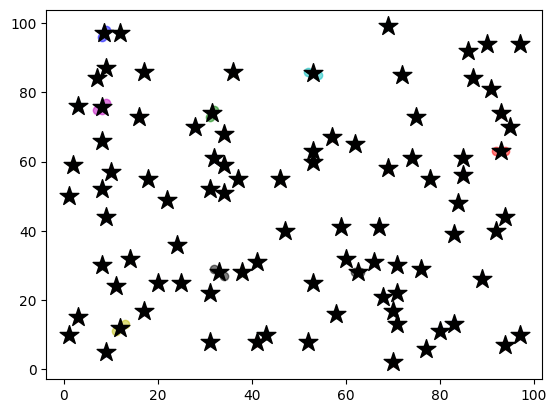

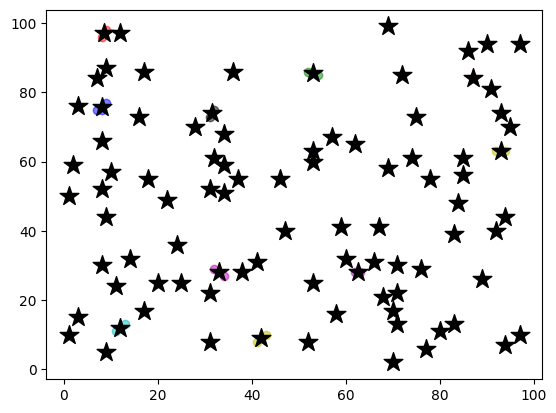

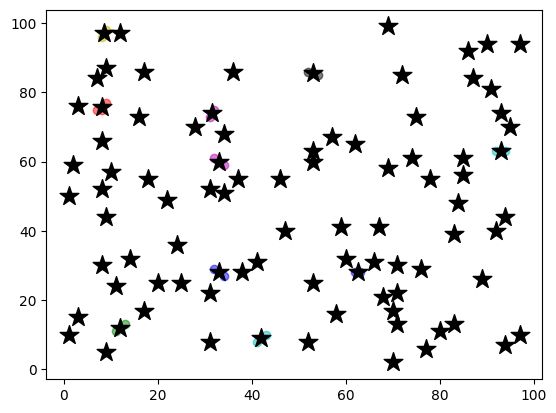

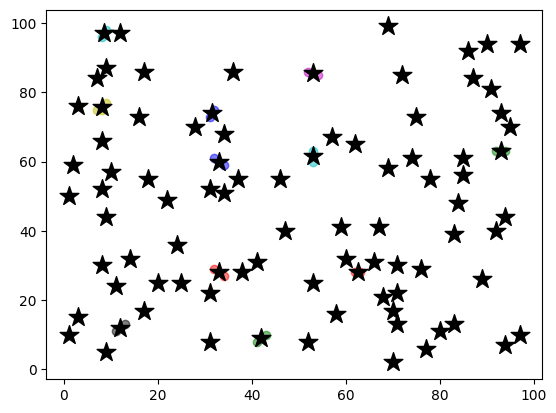

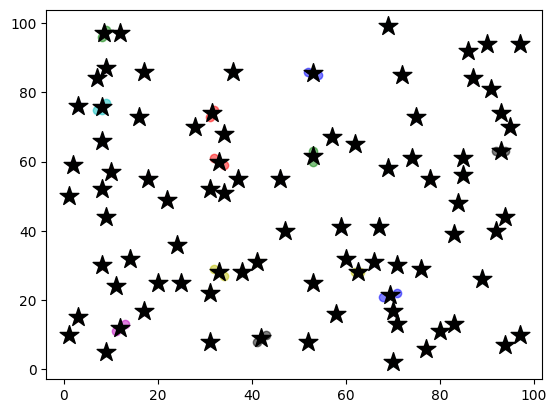

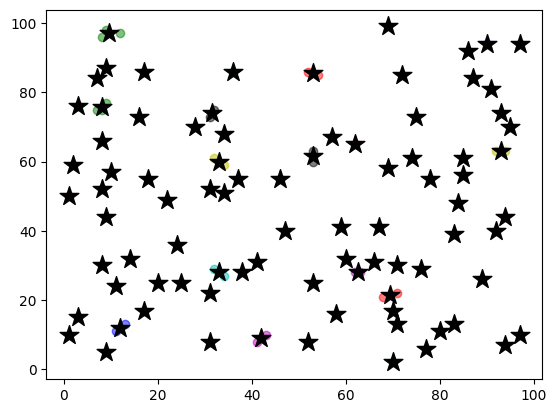

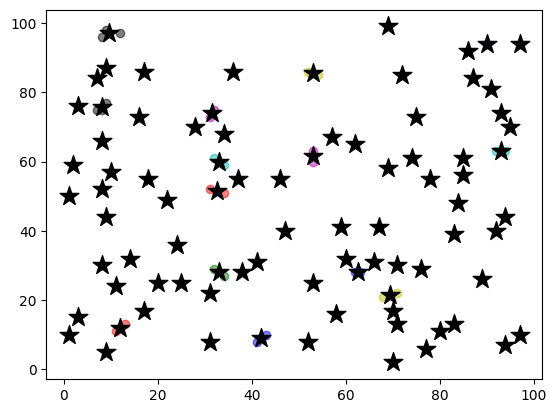

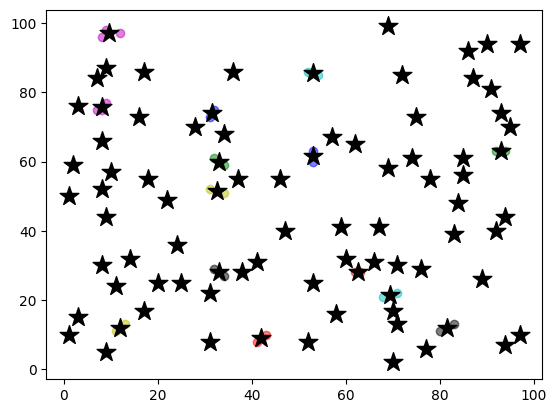

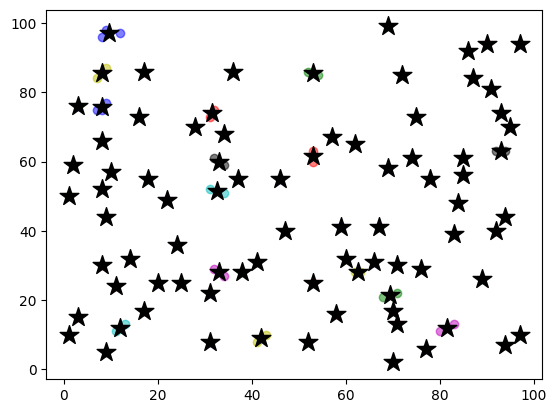

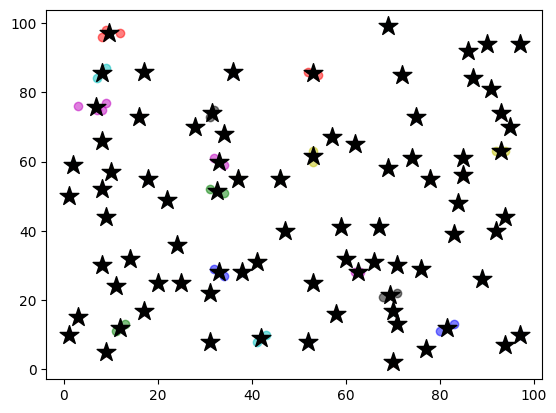

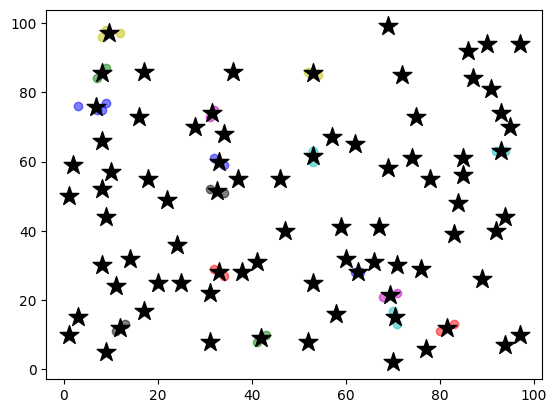

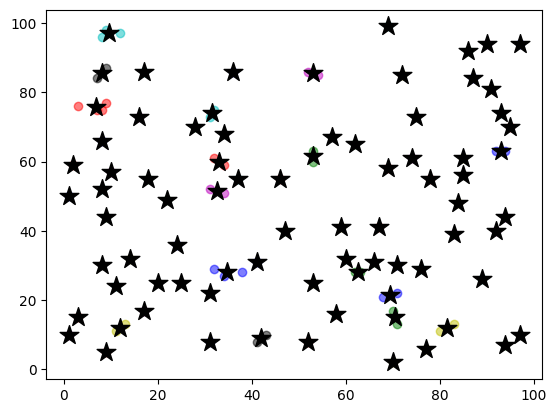

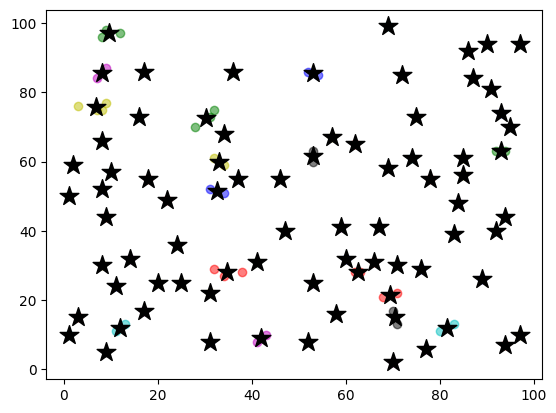

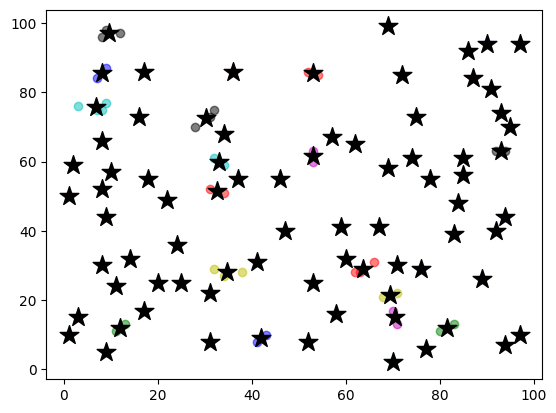

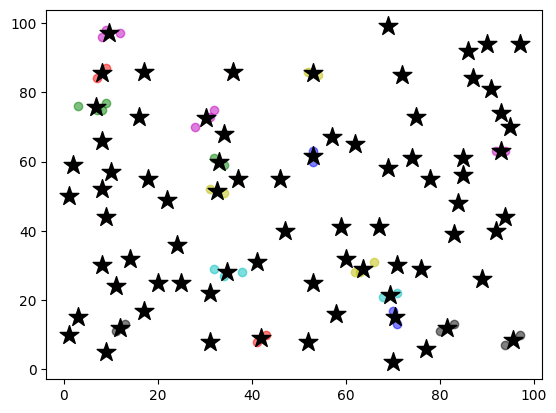

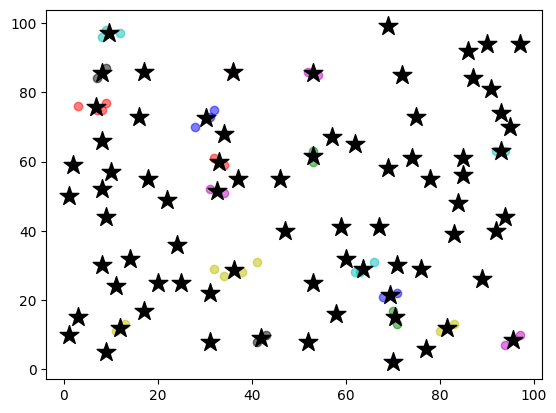

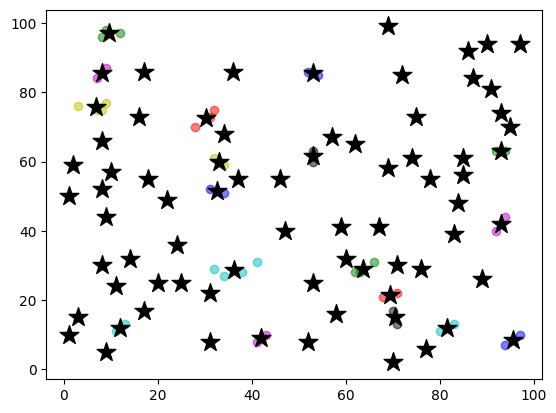

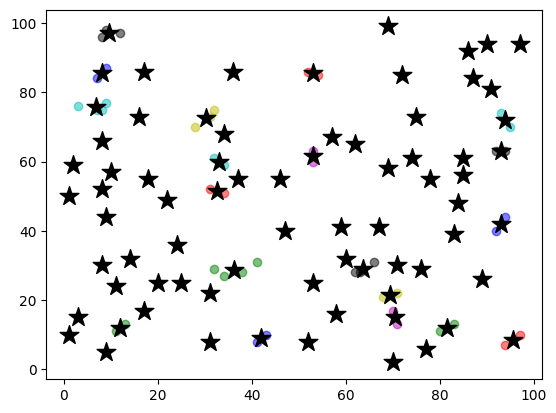

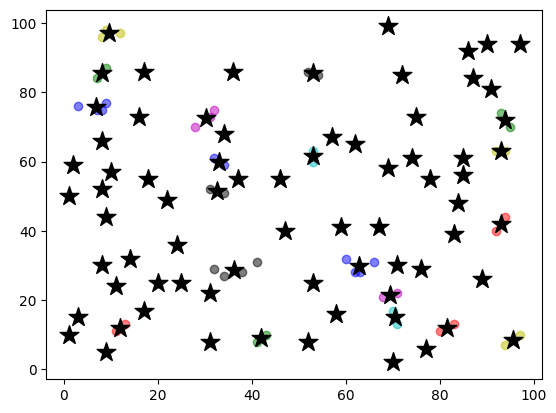

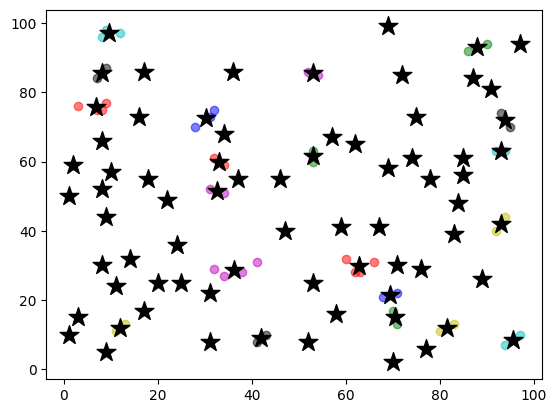

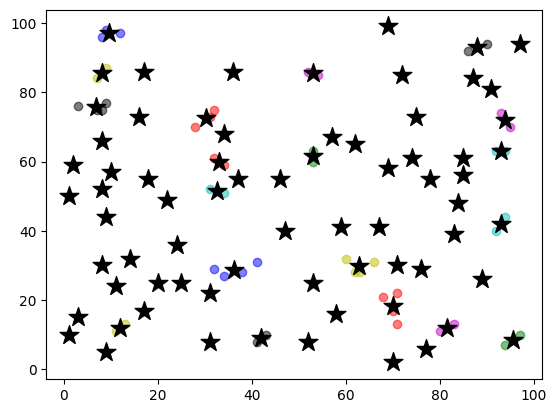

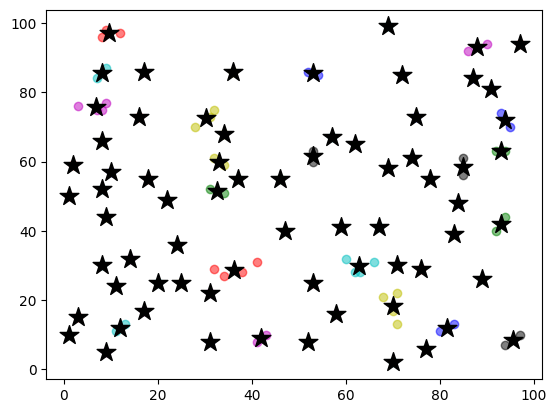

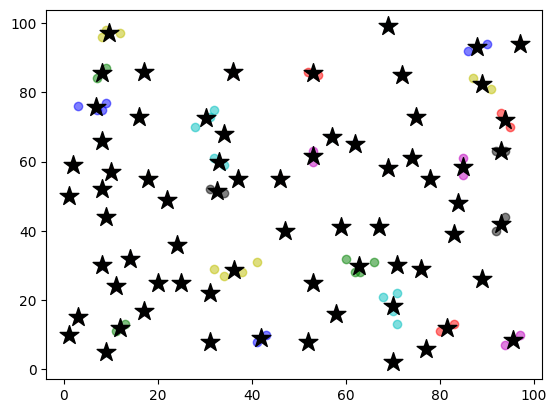

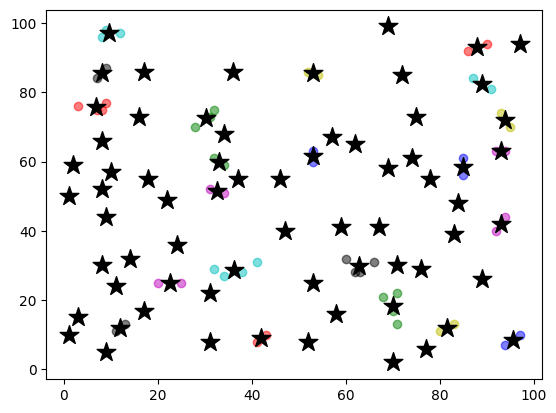

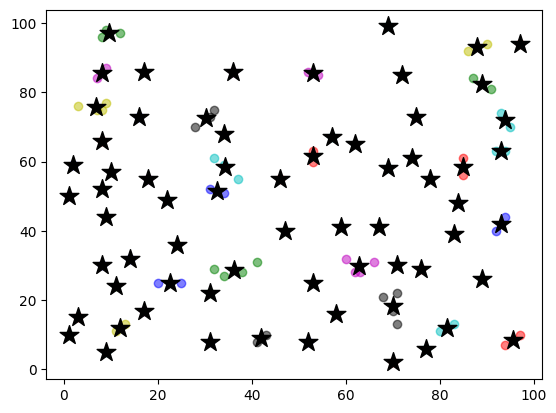

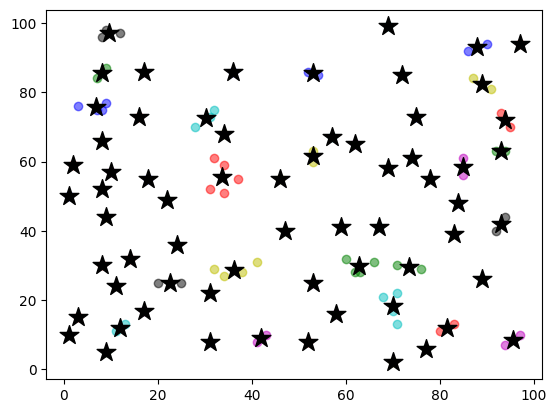

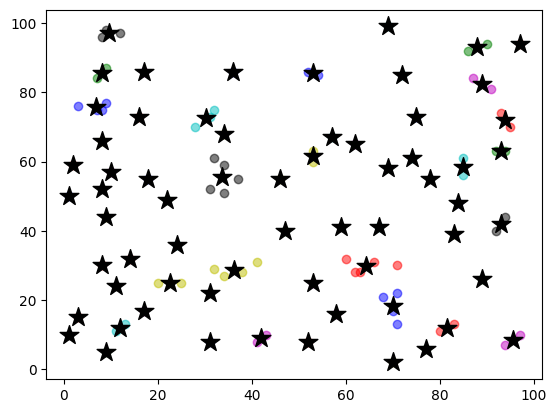

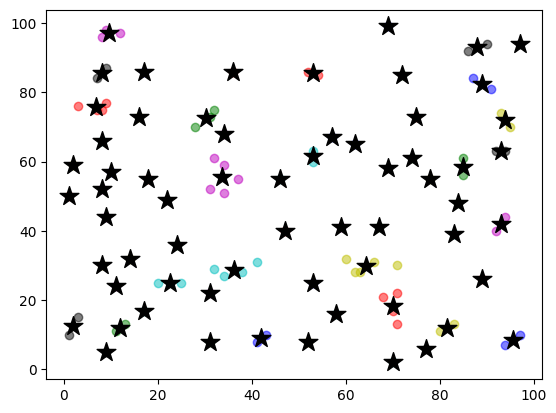

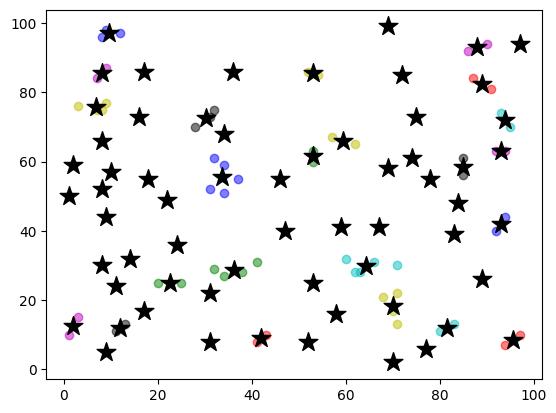

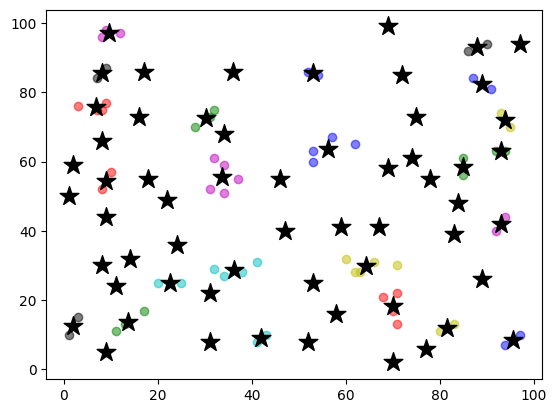

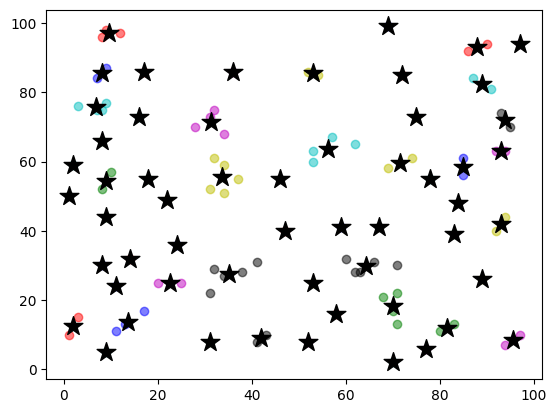

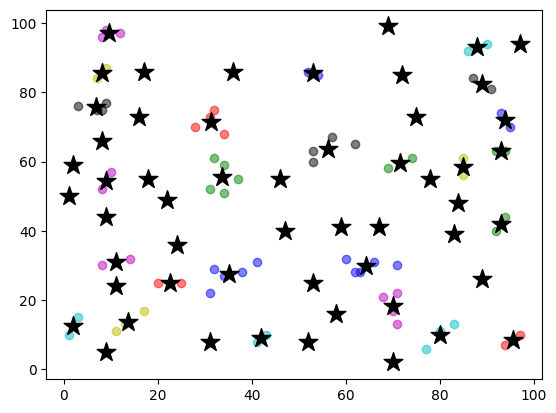

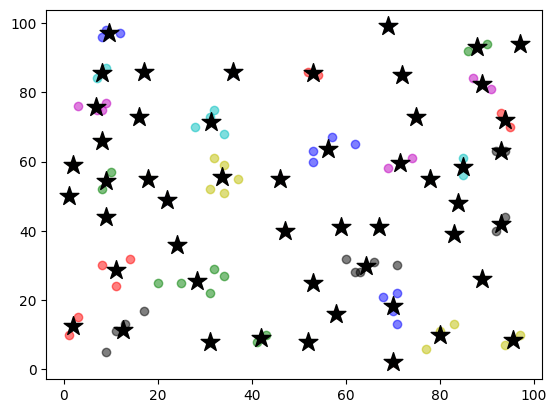

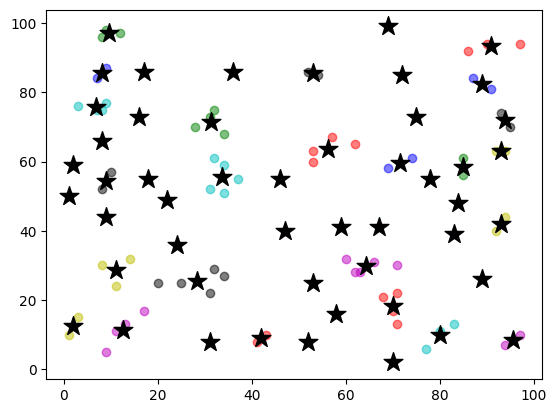

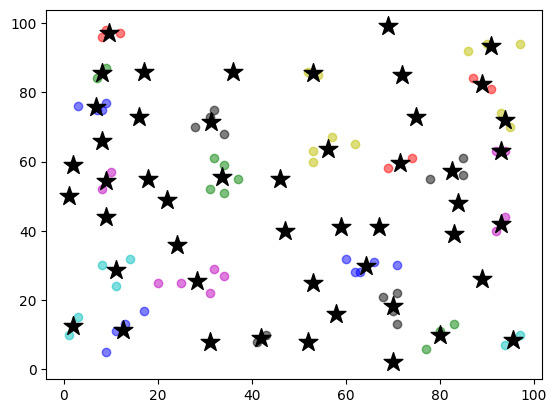

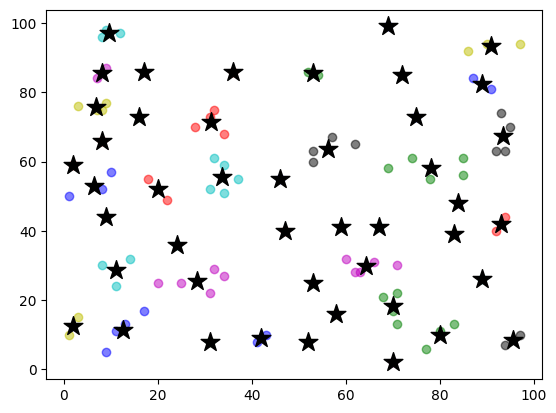

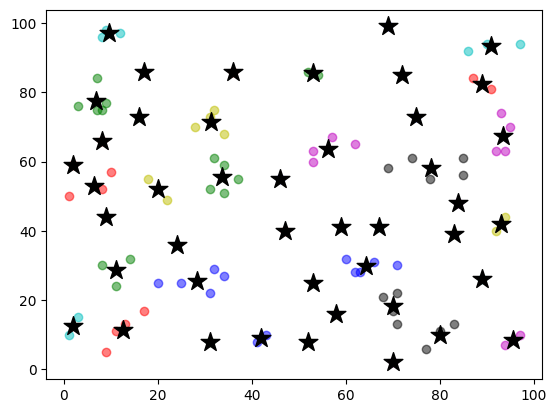

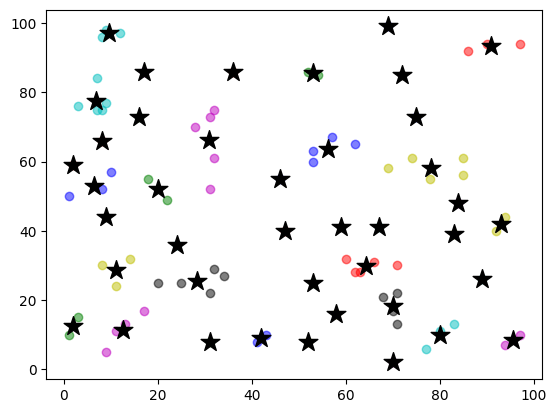

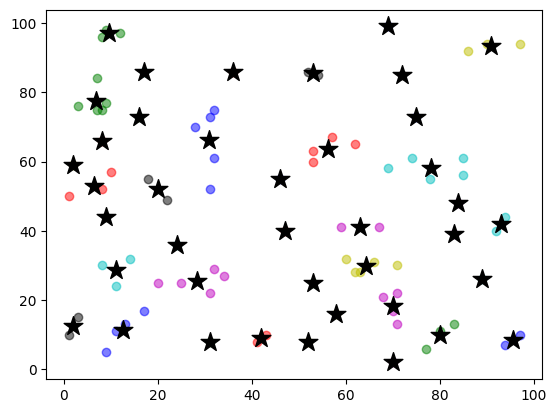

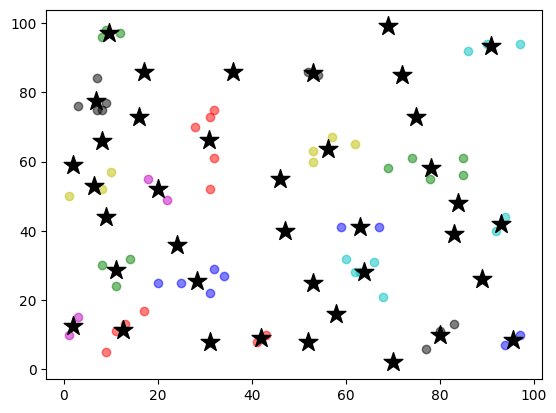

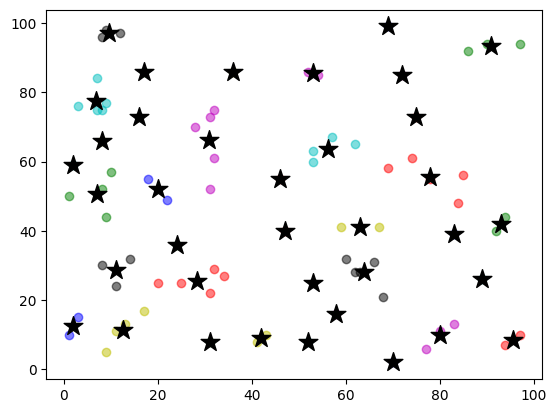

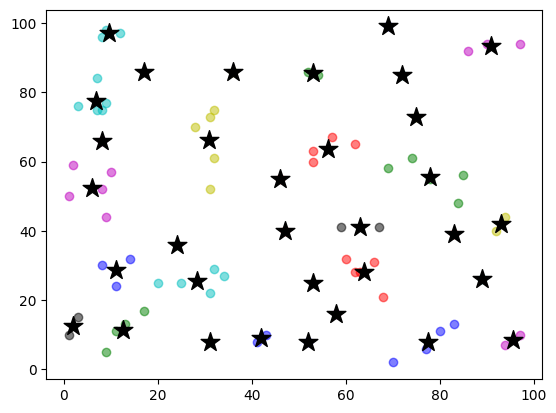

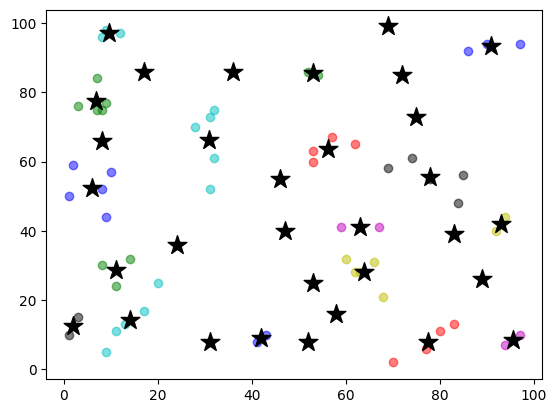

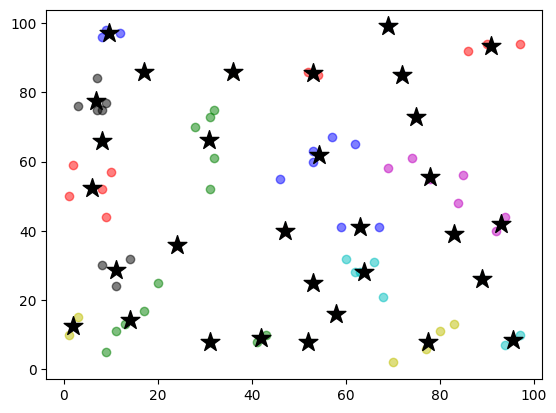

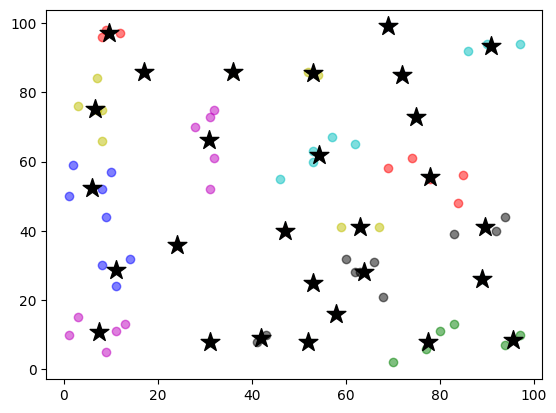

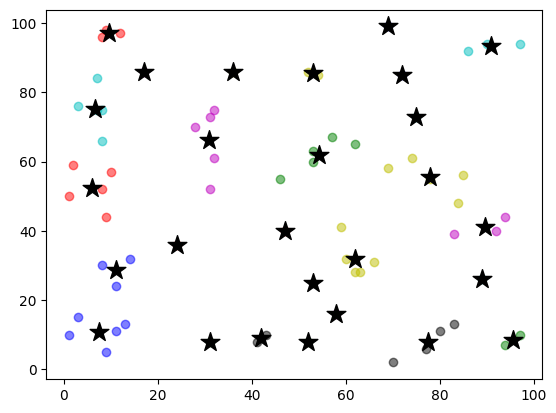

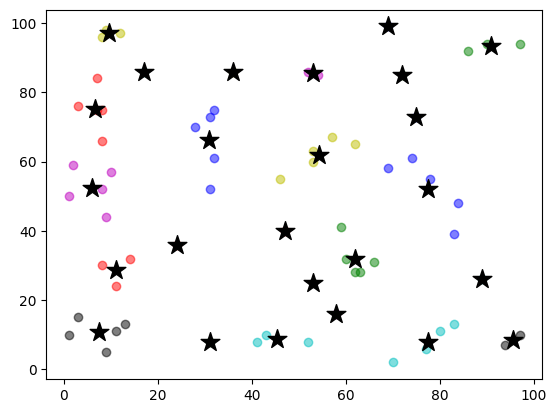

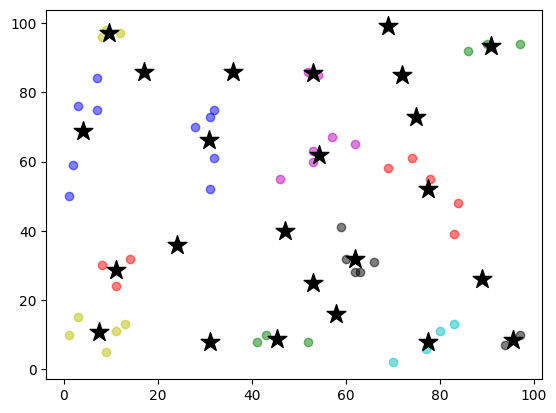

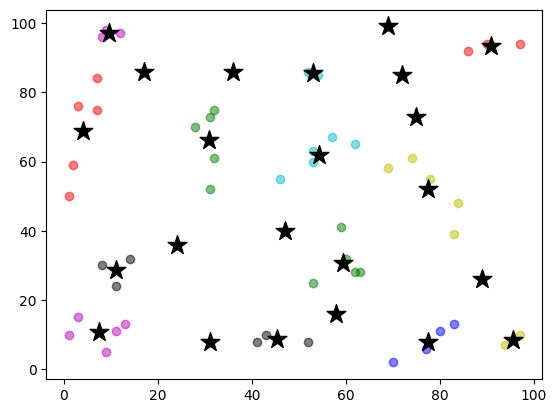

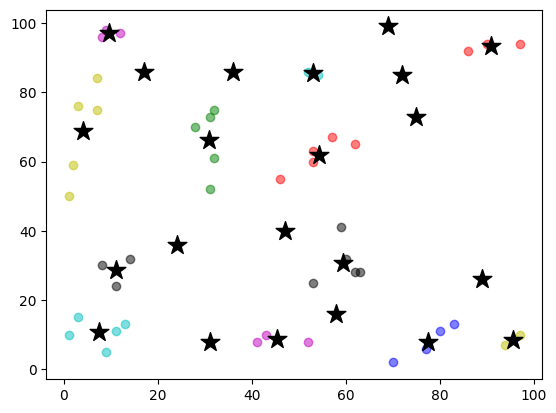

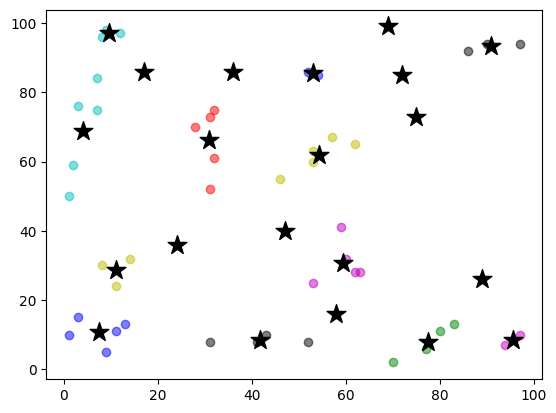

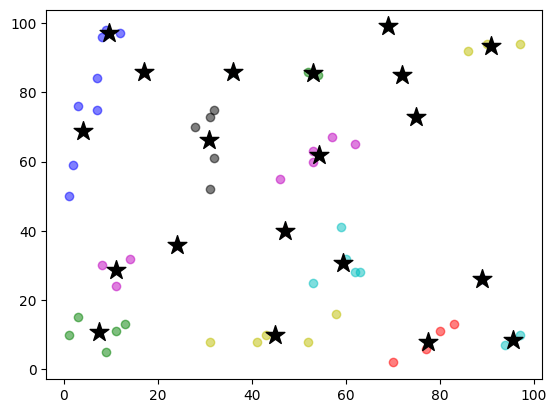

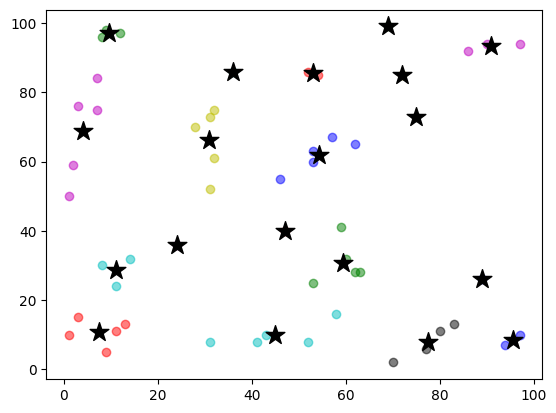

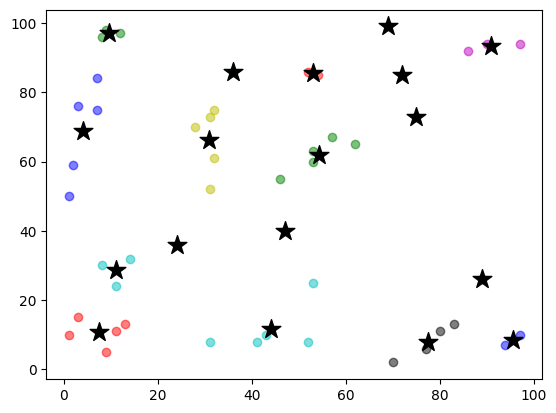

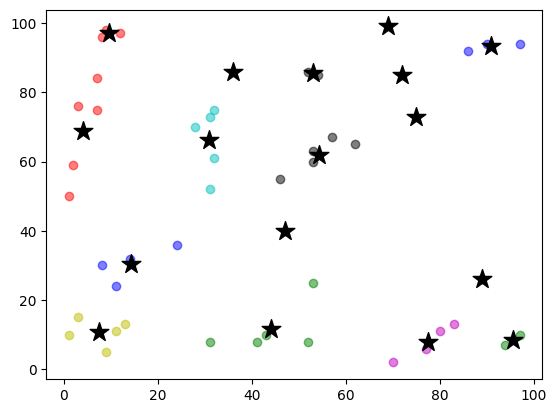

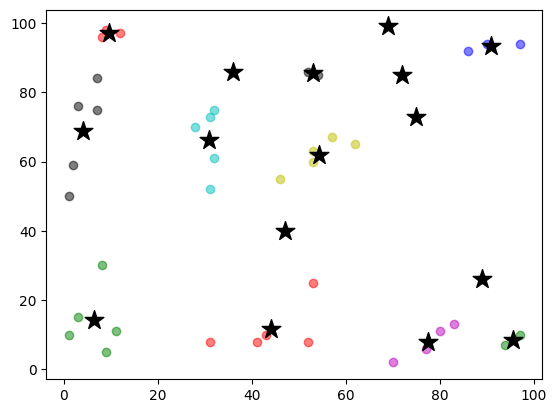

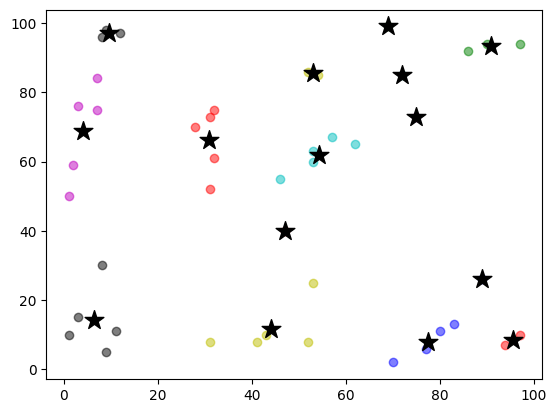

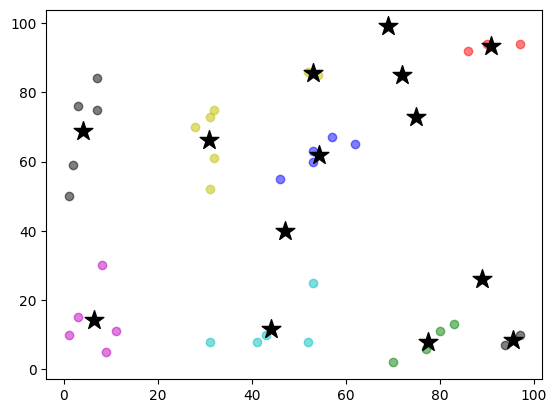

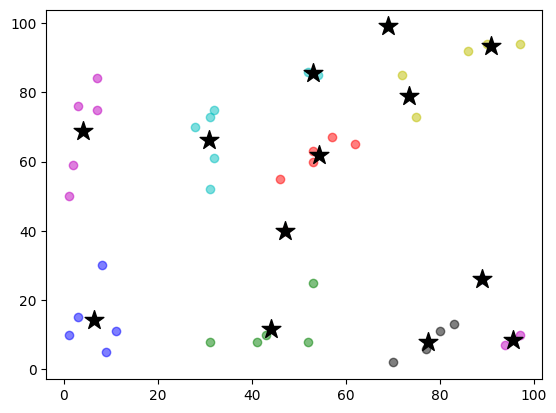

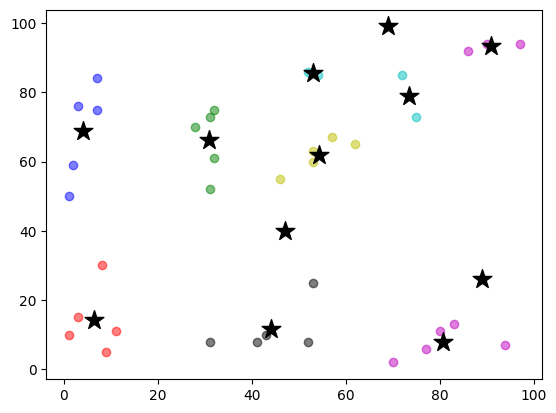

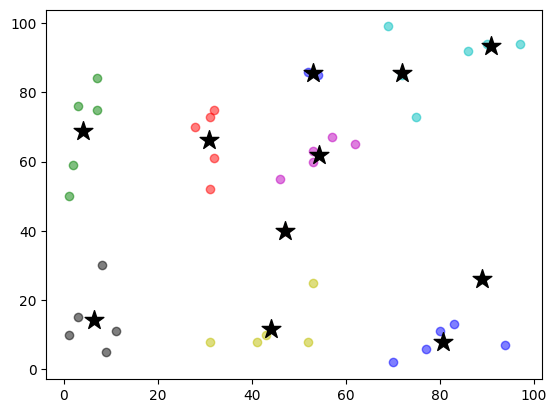

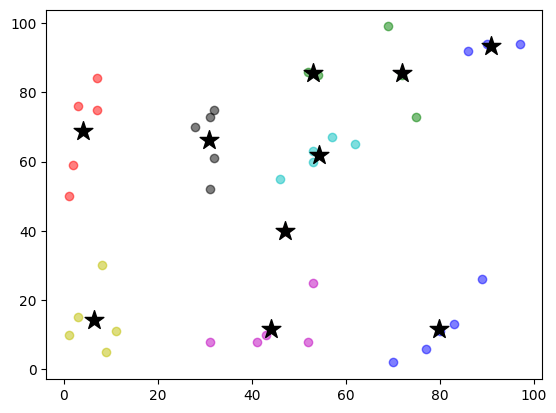

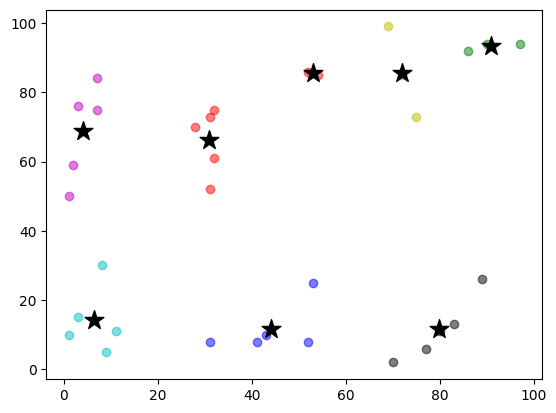

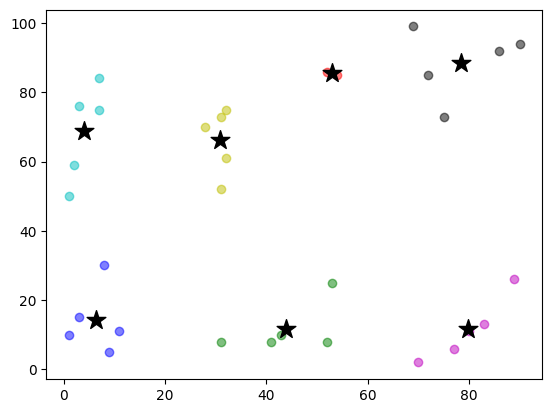

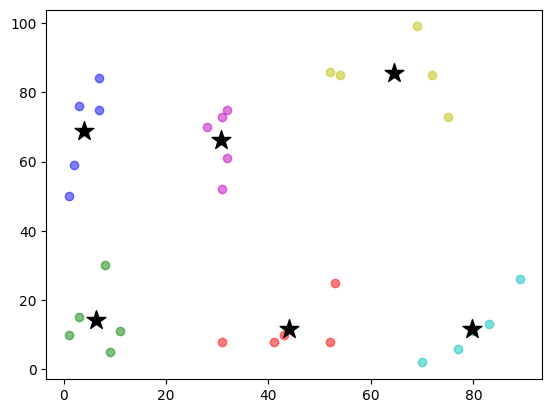

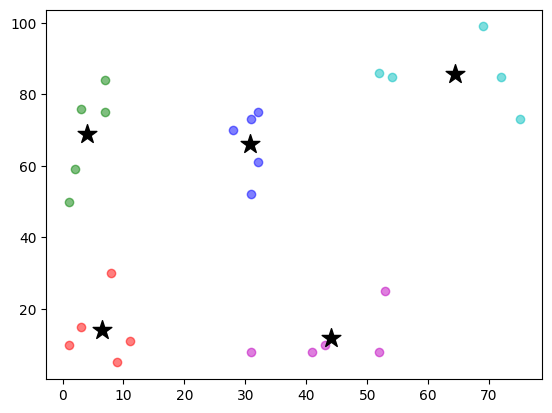

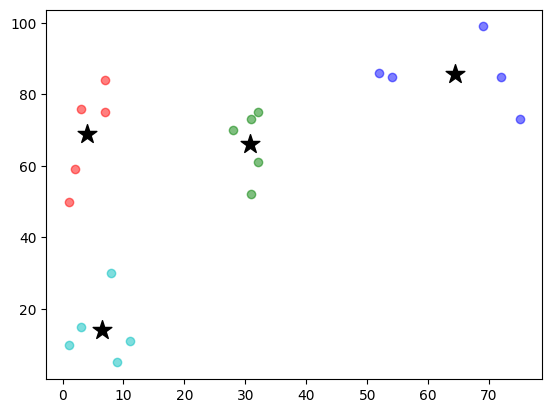

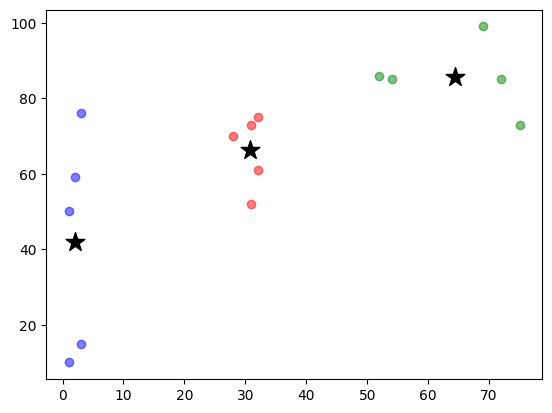

In [73]:
cure_clustering(df, k, 5)